In [1]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from analysis import *
from plots import *

%matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [2]:
output_dir = config['output_dir']
# output_dir = './psd_output/'
output_dir = './opto_tagged_entrainment_v1_output/'

## Select sessions for analysis

In [3]:
# Read session selection
session_selection_file = 'session_selection'
# session_selection_file = 'session_selection_all'

session_selection = pd.read_csv(os.path.join(output_dir, session_selection_file + '.csv'), index_col='session_id')

#### Additional filter

In [4]:
genotype = []
session_dir_exist = []
for session_id, row in session_selection.iterrows():
    session_dir_exist.append(os.path.isdir(os.path.join(output_dir, f'session_{session_id:d}')))
    genotype.append(row['full_genotype'].split('/', 1)[0].split('-', 1)[0])

session_selection['session_dir_exist'] = session_dir_exist
session_selection['genotype'] = genotype
session_selection['laser'] = session_selection.index >= 789848216

In [5]:
select_session_type = None
# select_session_type = 'functional_connectivity'
# select_session_type = 'brain_observatory_1.1'

select_psd = False
select_laser = False


select_idx = session_selection['session_dir_exist']
select_idx &= (session_selection['genotype'] == 'Pvalb') | (session_selection['genotype'] == 'Sst')

if select_session_type is not None:
    select_idx &= session_selection['session_type'] == select_session_type

if select_psd:
    select_idx &= session_selection['psd good']

if select_laser:
    select_idx &= session_selection['laser']

session_selection = session_selection[select_idx].copy()

#### Get probe directory

In [6]:
probe_dirs = []
for session_id, row in session_selection.iterrows():
    session_dir = os.path.join(output_dir, f'session_{session_id:d}')
    ecephys_structure_acronym = row['ecephys_structure_acronyms']
    info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
    if os.path.isfile(info_file):
        with open(info_file) as f:
            probe_id = json.load(f)['probe_id']
            probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
    else:
        for probe_dir in os.listdir(session_dir):
            if probe_dir.startswith('probe_'):
                probe_dir = os.path.join(session_dir, probe_dir)
                break
        else:
            probe_dir = ''
    if not os.path.isdir(probe_dir):
        print(f"Missing probe directory for session {session_id:d}")
        raise FileNotFoundError(probe_dir)
    probe_dirs.append(probe_dir)

session_selection['probe_dir'] = probe_dirs

In [7]:
session_selection

,session_type,full_genotype,ecephys_structure_acronyms,psd good,session_dir_exist,genotype,laser,probe_dir
session_id,,,,,,,,
715093703,brain_observatory_1.1,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,False,True,Sst,False,./opto_tagged_entrainment_v1_output/session_71...
719161530,brain_observatory_1.1,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,False,True,Sst,False,./opto_tagged_entrainment_v1_output/session_71...
721123822,brain_observatory_1.1,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,True,Pvalb,False,./opto_tagged_entrainment_v1_output/session_72...
746083955,brain_observatory_1.1,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,True,Pvalb,False,./opto_tagged_entrainment_v1_output/session_74...
756029989,brain_observatory_1.1,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,True,True,Sst,False,./opto_tagged_entrainment_v1_output/session_75...
758798717,brain_observatory_1.1,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,False,True,Sst,False,./opto_tagged_entrainment_v1_output/session_75...
760345702,brain_observatory_1.1,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,False,True,Pvalb,False,./opto_tagged_entrainment_v1_output/session_76...
760693773,brain_observatory_1.1,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,False,True,Sst,False,./opto_tagged_entrainment_v1_output/session_76...
762602078,brain_observatory_1.1,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,VISp,False,True,Sst,False,./opto_tagged_entrainment_v1_output/session_76...


## Detect tagged units

In [8]:
genotypes = ['Pvalb', 'Sst']

ttest_alpha = {'Pvalb': None, 'Sst': None}  # alpha for t-test
evoked_ratio_threshold = {'Pvalb': 1.5, 'Sst': 2.0}  # threshold for ratio of evoked to baseline
spike_width_threshold = {'Pvalb': 0.45, 'Sst': None}  # ms. Spike width lower than this are PV

figsize = (3.6, 3)

In [9]:
optotag_df ={k: [] for k in genotypes}
n_unit_sessions = {}

for session_id, row in session_selection.iterrows():
    probe_dir, ecephys_structure_acronym = row['probe_dir'], row['ecephys_structure_acronyms']
    optotag_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_optotag_units.csv')
    if not os.path.isfile(optotag_file):
        print(f"Missing optotag file for session {session_id:d}")
        continue
    df = pd.read_csv(optotag_file, index_col='unit_id')
    df['session_id'] = session_id
    optotag_df[row['genotype']].append(df)
    n_unit_sessions[session_id] = df.shape[0]

for genotype in genotypes:
    df = pd.concat(optotag_df[genotype])  # concatenate units across sessions
    df, positive_units = detect_optotag(df, ttest_alpha=ttest_alpha[genotype],
        evoked_ratio_threshold=evoked_ratio_threshold[genotype],
        spike_width_threshold=spike_width_threshold[genotype])
    optotag_df[genotype] = df

Number of positive units: 42


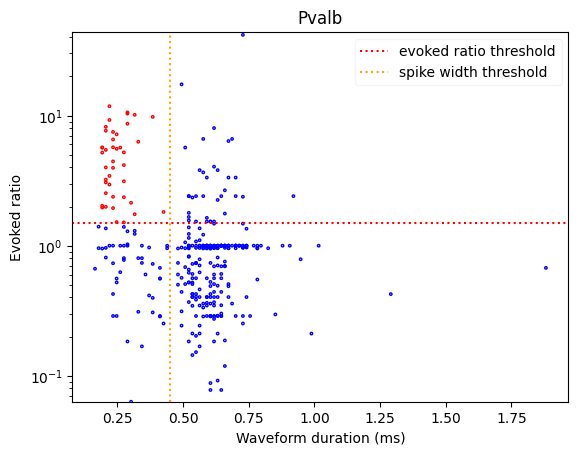

Number of positive units: 154


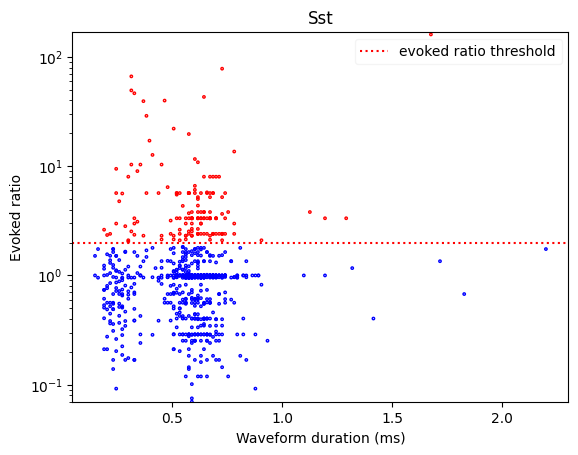

In [10]:
for genotype in genotypes:
    df = optotag_df[genotype]
    print(f"Number of positive units: {sum(df['positive']):d}")

    ax = plot_optotag_units(df, ttest_alpha=ttest_alpha[genotype],
        evoked_ratio_threshold=evoked_ratio_threshold[genotype],
        spike_width_threshold=spike_width_threshold[genotype])
    evoked_ratio = df['evoked_ratio']
    ax.set_ylim(bottom=np.min(evoked_ratio[evoked_ratio > 0]))
    ax.set_yscale('log')
    ax.set_title(genotype)

    plt.show()

## Analyze PPC

In [11]:
colors = {'beta': 'b', 'gamma': 'r'}
waves = list(colors)
n_waves = len(waves)


# Set the combination of stimuli
stimulus_names = {
    'brain_observatory_1.1': ['drifting_gratings', 'natural_movie_one', 'natural_movie_three'],
    'functional_connectivity': ['drifting_gratings_75_repeats', 'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']
}

In [12]:
n_positive = {}
for genotype, df in optotag_df.items():
    n_positive[genotype] = {}
    for session_type in stimulus_names:
        session_types = session_selection.loc[optotag_df[genotype]['session_id'], 'session_type'].values
        n_positive[genotype][session_type] = sum(df['positive'] & (session_types == session_type))
n_positive = pd.DataFrame.from_dict(n_positive, orient='index')
n_positive.index.name = 'genotype'
print('Number of positive units')
display(n_positive)

Number of positive units


,brain_observatory_1.1,functional_connectivity
genotype,,
Pvalb,23,19
Sst,73,81


### Load data and calculate

In [13]:
from collections import defaultdict

spike_phases = defaultdict(dict)
for session_id, row in session_selection.iterrows():
    probe_dir = row['probe_dir']
    ecephys_structure_acronym = row['ecephys_structure_acronyms']
    session_type = row['session_type']
    for stim in stimulus_names[session_type]:
        spike_phase_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stim:s}_spkie_phase.nc')
        if not os.path.isfile(spike_phase_file):
            print(f"Missing spike phase file for session {session_id:d}")
            continue
        spike_phase = xr.load_dataset(spike_phase_file)
        # recover complex values
        spike_phase = spike_phase.assign(resultant_phase=spike_phase.resultant_phase_real + \
            1j * spike_phase.resultant_phase_imag).drop_vars(['resultant_phase_real', 'resultant_phase_imag'])
        # Add to list
        spike_phases[stim][session_id] = spike_phase

In [14]:
ppc_all = {}  # in whole duration for each stimulus
ppc_windows = {}  # in windows for each stimulus
for genotype, df in optotag_df.items():
    ppc = defaultdict(list)
    ppc_win = defaultdict(lambda: defaultdict(list))
    for stim, spike_phase in spike_phases.items():
        for session_id, spk_pha in spike_phase.items():  # over sessions
            if session_selection.loc[session_id, 'genotype'] != genotype:
                continue
            unit_ids = [i for i in spk_pha.unit_id.values if df.loc[i, 'positive']]  # only positive units
            # whole duration
            ppc[stim].append(phase_locking_value(spk_pha, unit_ids=unit_ids, presentation_ids=None, unbiased=True))
            # window durations
            if spk_pha.window.size > 1:
                for win in spk_pha.window.values:
                    presentation_ids = spk_pha.presentation_ids.sel(window=win)
                    ppc_win[stim][win].append(phase_locking_value(spk_pha,
                        unit_ids=unit_ids, presentation_ids=presentation_ids.values, unbiased=True))
    # concatenate across sessions
    ppc_all[genotype] = {stim: xr.concat(x, dim='unit_id') for stim, x in ppc.items()}
    ppc_windows[genotype] = {stim: {win: xr.concat(y, dim='unit_id') for win, y in x.items()} \
                             for stim, x in ppc_win.items()}

### Plot PPC

Pvalb


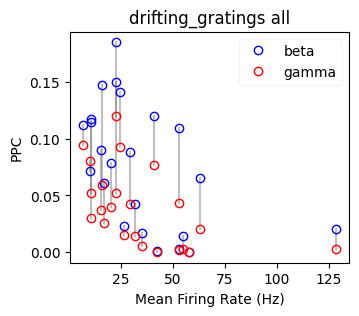

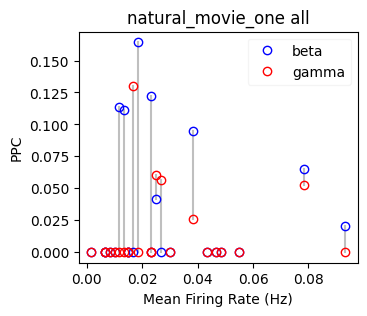

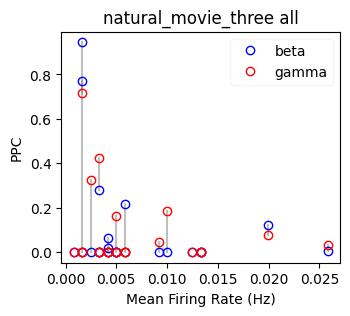

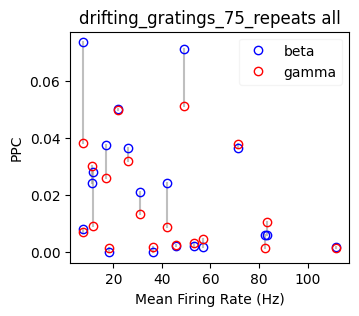

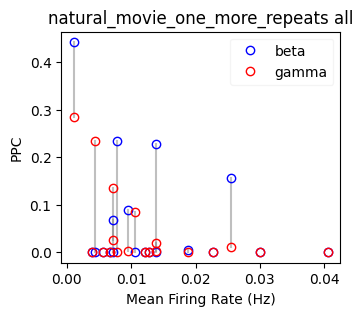

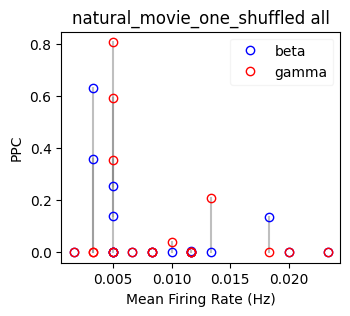

Sst


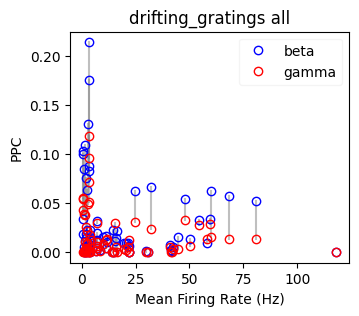

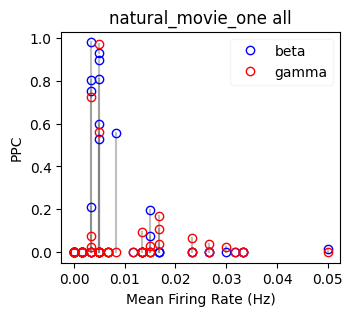

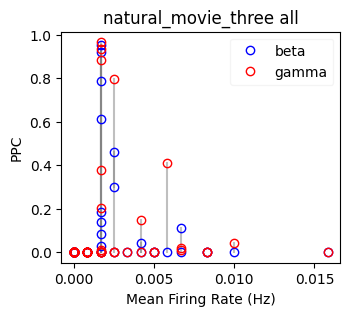

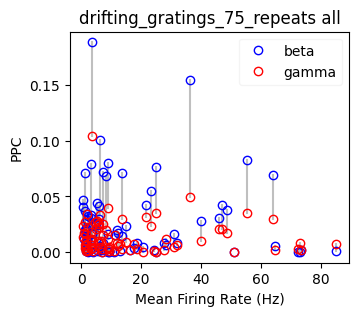

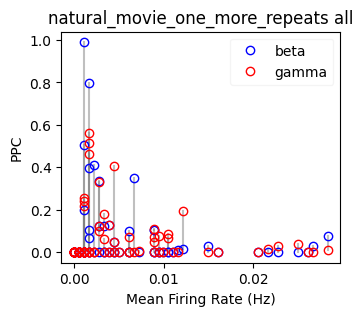

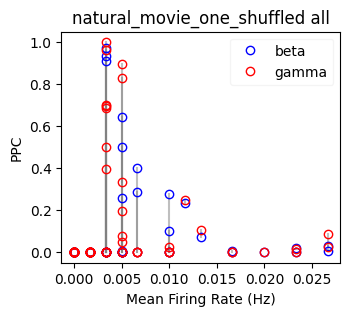

In [15]:
for genotype in genotypes:
    print(genotype)
    for stim, ppc in ppc_all[genotype].items():
        ppc_waves = []
        for w in waves:
            p = ppc.sel(wave=w)
            ppc_waves.append([p.mean_firing_rate, p.PPC])
        ppc_waves = np.array(ppc_waves)  # (wave, xy, units)

        _, ax = plt.subplots(1, 1, figsize=figsize)
        for cu in ppc_waves.swapaxes(0, -1):  # (units, xy, wave)
            ax.plot(*cu, color='gray', alpha=0.5)  # connect same unit
        for i, w in enumerate(waves):
            ax.plot(*ppc_waves[i], 'o', color=colors[w],
                    markerfacecolor='none', label=w)
        ax.set_xlabel("Mean Firing Rate (Hz)")
        ax.set_ylabel("PPC")
        ax.set_title(f'{stim:s} all')
        ax.legend(loc='upper right', framealpha=0.2)
        plt.show()

Pvalb


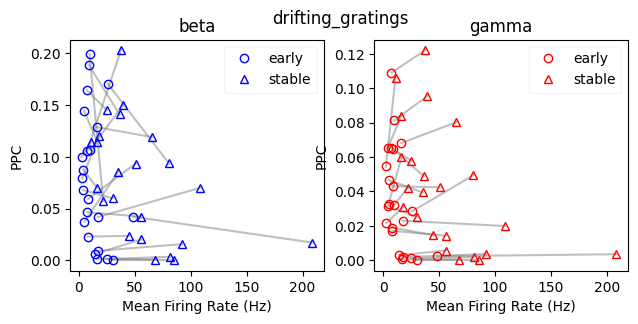

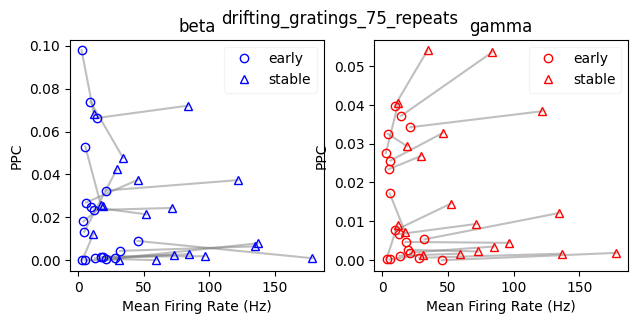

Sst


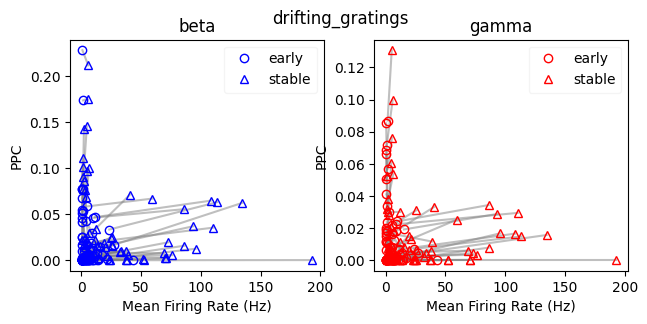

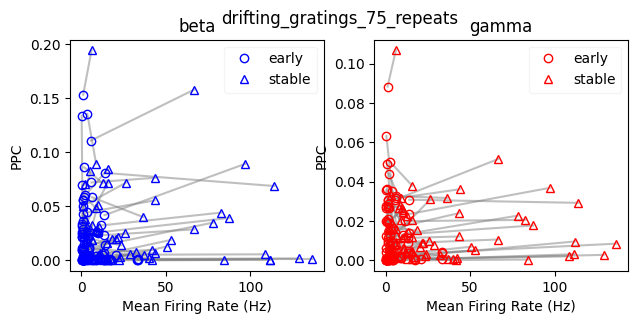

In [16]:
win_markers = ['o', '^']

for genotype in genotypes:
    print(genotype)
    for stim, ppc_win in ppc_windows[genotype].items():
        ppc_wins = []
        for win, ppc in ppc_win.items():
            ppc_waves = []
            for w in waves:
                p = ppc.sel(wave=w)
                ppc_waves.append([p.mean_firing_rate, p.PPC])
            ppc_wins.append(ppc_waves)
        ppc_wins = np.array(ppc_wins).swapaxes(0, 1)  # (wave, windows, xy, units)

        fig, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
        for i, w in enumerate(waves):
            ax = axs[i]
            for cu in ppc_wins[i].swapaxes(0, -1):  # (units, xy, windows)
                ax.plot(*cu, color='gray', alpha=0.5)  # connect same unit
            for j, win in enumerate(ppc_win):
                ax.plot(*ppc_wins[i, j], linestyle='none', marker=win_markers[j],
                        color=colors[w], markerfacecolor='none', label=f'{win:s}')
            ax.set_xlabel("Mean Firing Rate (Hz)")
            ax.set_ylabel("PPC")
            ax.set_title(w)
            ax.legend(loc='upper right', framealpha=0.2)
        fig.suptitle(stim)
        plt.show()

### List average PPC

In [25]:
stim_windows = []
ppc_df = defaultdict(dict)
for genotype in genotypes:
    for stim, ppc in ppc_all[genotype].items():
        ppcs = []
        stim_wins = []
        stim_win = f'{stim:s} whole'
        if stim_win not in stim_windows:
            stim_windows.append(stim_win)
        ppcs.append(ppc)
        stim_wins.append(stim_win)
        if stim in ppc_windows[genotype]:
            for win, ppc in ppc_windows[genotype][stim].items():
                stim_win = f'{stim:s} {win:s}'
                if stim_win not in stim_windows:
                    stim_windows.append(stim_win)
                ppcs.append(ppc)
                stim_wins.append(stim_win)
        for stim_win, ppc in zip(stim_wins, ppcs):
            ppc_df[(genotype, 'mean firing rate')][stim_win] = ppc.mean_firing_rate.mean().item()
            ppc_df[(genotype, 'std firing rate')][stim_win] = ppc.mean_firing_rate.std().item()
            for w in waves:
                ppc_df[(genotype, 'PPC ' + w)][stim_win] = ppc.sel(wave=w).PPC.mean().item()

ppc_df = pd.DataFrame(ppc_df, index=pd.Index(stim_windows, name='stimulus duration'),
                      columns=pd.MultiIndex.from_tuples(list(ppc_df)))

with pd.option_context('display.float_format', '{:.3g}'.format, 'display.max_columns', None):
    for genotype in genotypes:
        print(ppc_df.loc[:, (genotype, slice(None))])

# ppc_df.to_csv(os.path.join('results', 'entrainment.csv'))

                                                Pvalb                  \
                                     mean firing rate std firing rate   
stimulus duration                                                       
drifting_gratings whole                          34.5              26   
drifting_gratings early                          13.1            10.7   
drifting_gratings stable                         55.9              42   
natural_movie_one whole                        0.0285          0.0229   
natural_movie_three whole                     0.00702         0.00615   
drifting_gratings_75_repeats whole               41.3            28.8   
drifting_gratings_75_repeats early               14.5            11.1   
drifting_gratings_75_repeats stable                68            46.8   
natural_movie_one_more_repeats whole           0.0134         0.00984   
natural_movie_one_shuffled whole              0.00929         0.00588   

                                                  